# Suspicious cases detection

In [2]:
%%capture 
%run "./shared.ipynb"

In [27]:
from python.suspicious_cases_prediction.model import SuspiciousModel
from python.suspicious_cases_prediction.visualization import plot_suspicions_stats

## Data loading

In [3]:
batch_size = 32
epochs = 8
IMG_HEIGHT = 240
IMG_WIDTH = 240

model_path = '../models/brats19_hgglgg_4.h5'

In [7]:
train_dir = '../data/train/confidence_19/'
val_dir = '../data/valid/confidence_19/'
test_dir = '../data/test/confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse')

Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


### Visualization of data

In [8]:
sample_training_images, l = next(train_data_gen)
sample_training_images.shape

(32, 240, 240, 3)

[0. 0. 0. 1. 1.]


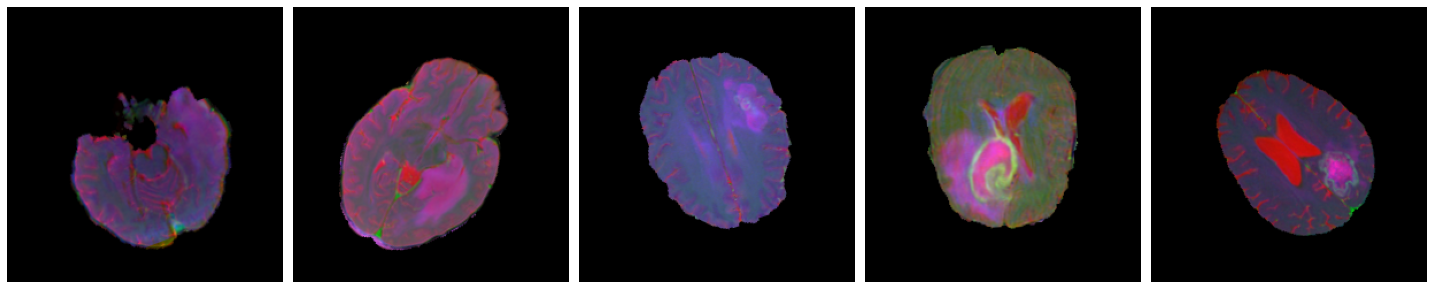

In [10]:
print(l[:5])
visualization.plot_rgb_images(sample_training_images[:5])

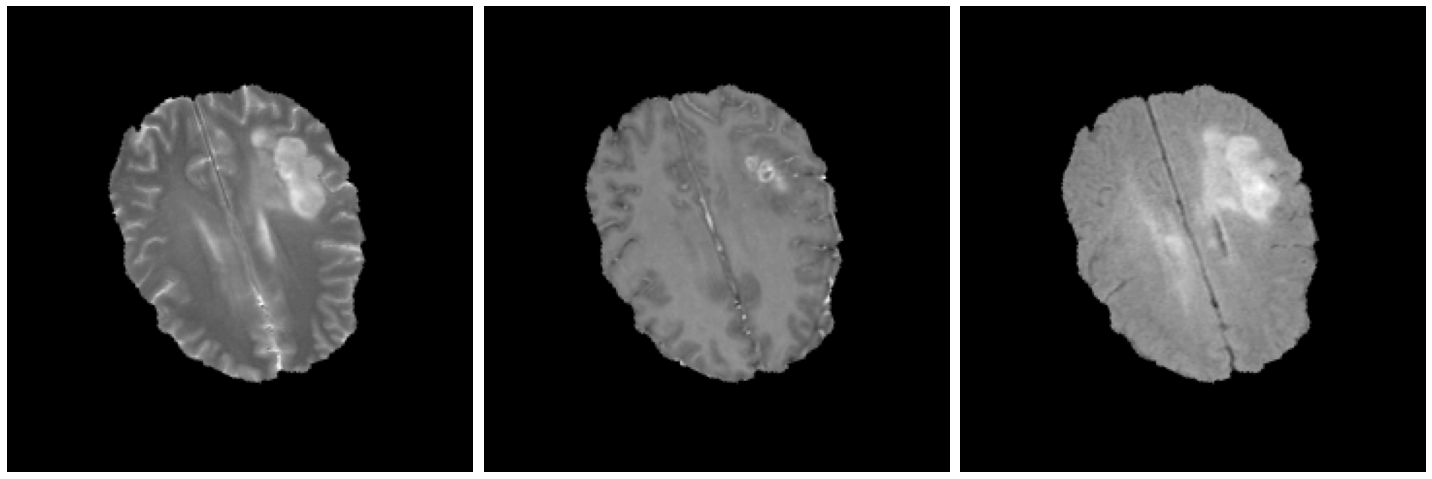

In [11]:
visualization.plot_rgb_decomposition(sample_training_images[2])

## Model definition and training

In [ ]:
model = model_keras.initialize_brats_model(IMG_HEIGHT, IMG_WIDTH)

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=1645 // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=446 // batch_size
)

Train for 25 steps, validate for 6 steps
Epoch 1/8
25/25 [==============================] - 17s 666ms/step - loss: 0.6974 - accuracy: 0.4877 - val_loss: 0.6924 - val_accuracy: 0.4479
Epoch 2/8
25/25 [==============================] - 17s 665ms/step - loss: 0.6598 - accuracy: 0.6173 - val_loss: 0.6635 - val_accuracy: 0.5755
Epoch 3/8
25/25 [==============================] - 17s 670ms/step - loss: 0.6003 - accuracy: 0.6799 - val_loss: 0.6200 - val_accuracy: 0.6042
Epoch 4/8
25/25 [==============================] - 16s 648ms/step - loss: 0.5815 - accuracy: 0.6856 - val_loss: 0.6446 - val_accuracy: 0.5703
Epoch 5/8
25/25 [==============================] - 15s 617ms/step - loss: 0.5537 - accuracy: 0.7008 - val_loss: 0.6628 - val_accuracy: 0.6667
Epoch 6/8
25/25 [==============================] - 16s 640ms/step - loss: 0.5302 - accuracy: 0.7211 - val_loss: 0.6566 - val_accuracy: 0.6849
Epoch 7/8
25/25 [==============================] - 16s 638ms/step - loss: 0.4995 - accuracy: 0.7268 - val_l

### Evaluation of model

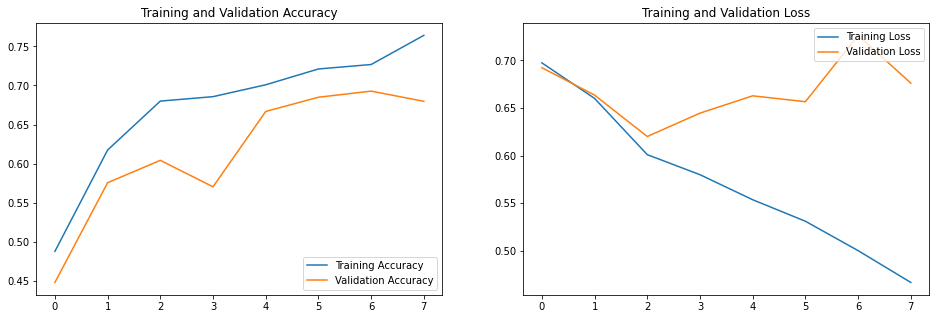

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model performance:
              precision    recall  f1-score   support

         0.0       0.64      0.65      0.64       195
         1.0       0.72      0.71      0.72       251

    accuracy                           0.69       446
   macro avg       0.68      0.68      0.68       446
weighted avg       0.69      0.69      0.69       446



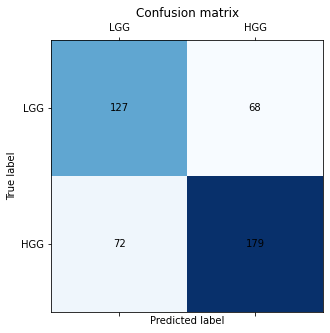

In [13]:
y_true_v = []
pred_v = []
iterations = 428 / batch_size
for i, (images, labels) in enumerate(val_data_gen):
    if i > iterations:
        break
    prob = model.predict(images)
    p = prob.argmax(axis=1)
    pred_v.extend(p)
    y_true_v.extend(labels)
plots.plot_model_performance(y_true_v, pred_v)

In [15]:
# Save the model
model.save('../models/brats19_3.h5');

## Suspicious cases detection

In [14]:
# We load pre-trained model
model = load_model('../models/brats19_3.h5')

### Data load
We load validation data to train our Suspicious classifier and test data to test detection of suspicious cases

In [34]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse',
                                                           seed=42)
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse',
                                                           seed=42)

Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


#### We will transform data form generator to collection of images

In [35]:
train_images, train_labels, train_pred, test_images, test_labels, test_pred = [], [], [], [], [], []
for _ in range(round(val_data_gen.samples / batch_size)):
    (images, labels) = val_data_gen.next()
    train_images.extend(images)
    train_labels.extend(labels)
    train_pred.extend(model.predict(images).argmax(1))
for _ in range(round(test_data_gen.samples / batch_size)):
    (images, labels) = test_data_gen.next()
    test_images.extend(images)
    test_labels.extend(labels)
    test_pred.extend(model.predict(images).argmax(1))
    
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_pred = np.array(train_pred)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_pred = np.array(test_pred)

### Suspicious Cases Wrapper
Here we wrapp our pre-trained model with Suspicious Cases Wrapper, which select hidden layers and train KNN model on every layer

In [36]:
model.layers

In [25]:
# model with layers outputs
layers_model = SuspiciousModel(model, [5, 7, 9, 12], ["LGG", "HGG"])

#### Train Suspicious Cases Classifier with training data (Validation set of whole brats dataset)
Suspicious Cases Classifier is trained in steps:
* The wrapper as the first split training data to two collections in ratio 60%:40%
* The first data collection is used to train KNN classifier on every from selected layers
* The second data collection is used to create taining data for classifier (outputs from KNN classifiers are concatenated to single vector for each case from second collection)
* In the final we have classifier ready to predict suspicious cases

In [26]:
layers_model.train(train_images, train_labels, train_pred)

### Evaluate suspicious prediction

#### When we predict LGG 

In [44]:
pred = layers_model.predict(test_images[test_pred==0], 0)

Analysis of cases predicted as LGG


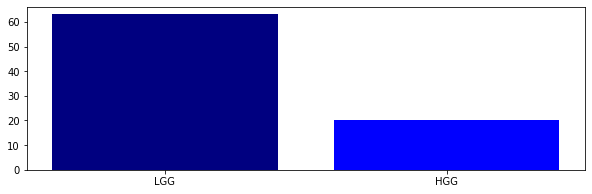

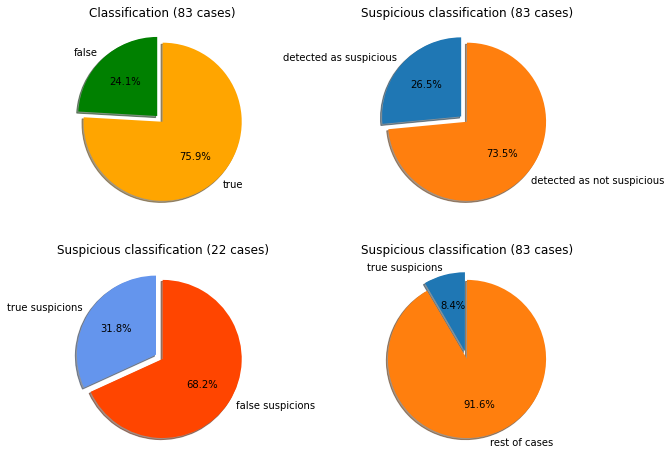

In [38]:
plot_suspicions_stats(pred, test_labels[test_pred==0], 0, ["LGG", "HGG"])

#### When we predict HGG

In [41]:
pred = layers_model.predict(test_images[test_pred==1], 1)

Analysis of cases predicted as HGG


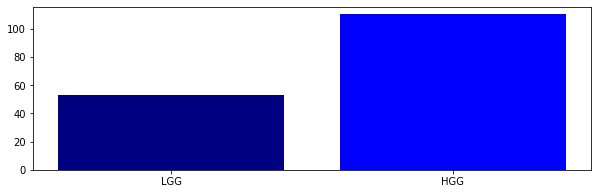

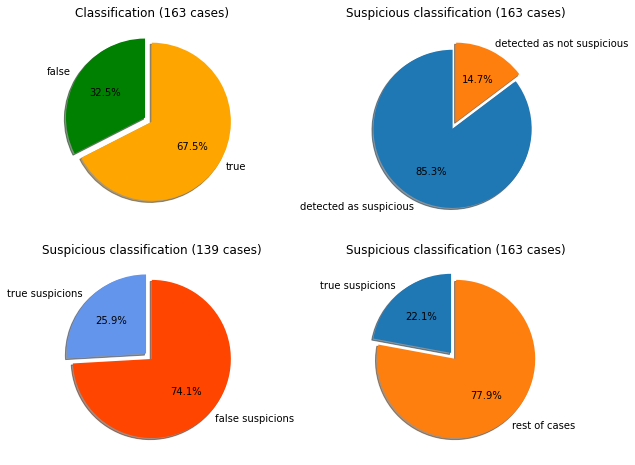

In [42]:
plot_suspicions_stats(pred, test_labels[test_pred==1], 1, ["LGG", "HGG"])

## Visualization of the most similar atlas images in prediction

In [45]:
label = 0

susp_imgs = test_images[test_pred == label][pred]

susp_labels = test_labels[test_pred == label][pred]

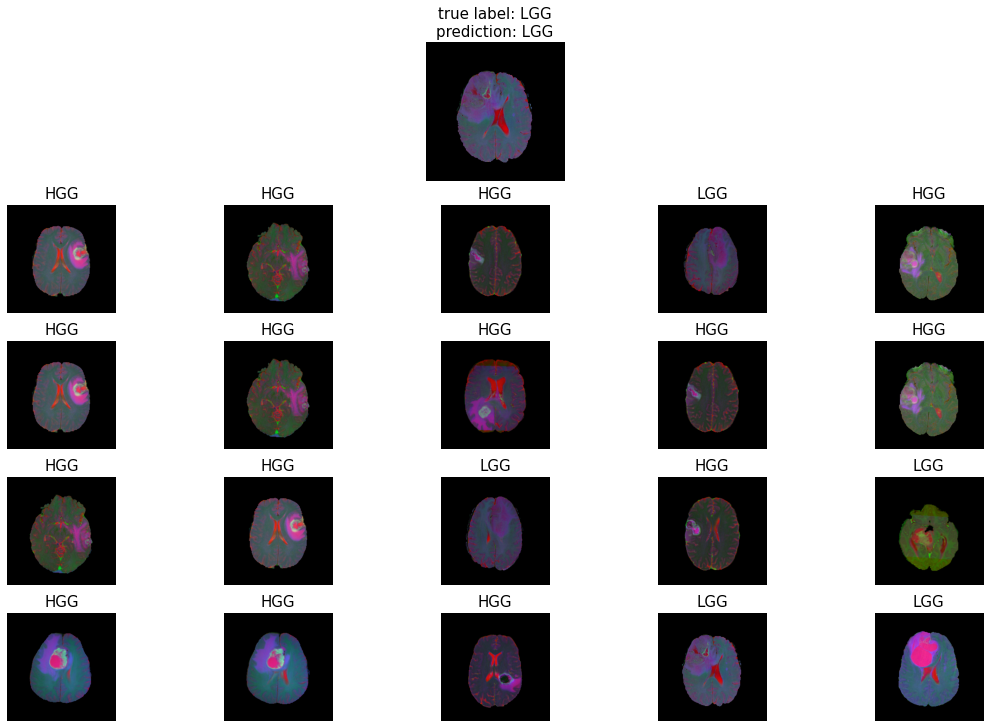

In [61]:
layers_neighbours_idxs = [layers_model.layer_models[l].get_neighbours_idx(np.array([image]))[0]
    for l in range(4)]
image_idx = 0

fig3 = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig3.add_gridspec(2, 2, height_ratios = [1, 3])
visualization.visualize_single_image(
    image,
    true_label,
    label,
    ["LGG", "HGG"],
    gs[0,:]
)
visualization.visualize_path(
    layers_neighbours_idxs,
    test_images,
    test_labels,
    ["LGG", "HGG"],
    gs[1,:]
)

#### Visualize LRP of most similar images

In [52]:
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_b", model, epsilon=1)

/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/relevance_based/relevance_analyzer.py:557: DeprecationWarning: LRPSequentialPresetB is deprecated. Use LRPSequentialCompositeB instead
  DeprecationWarning)


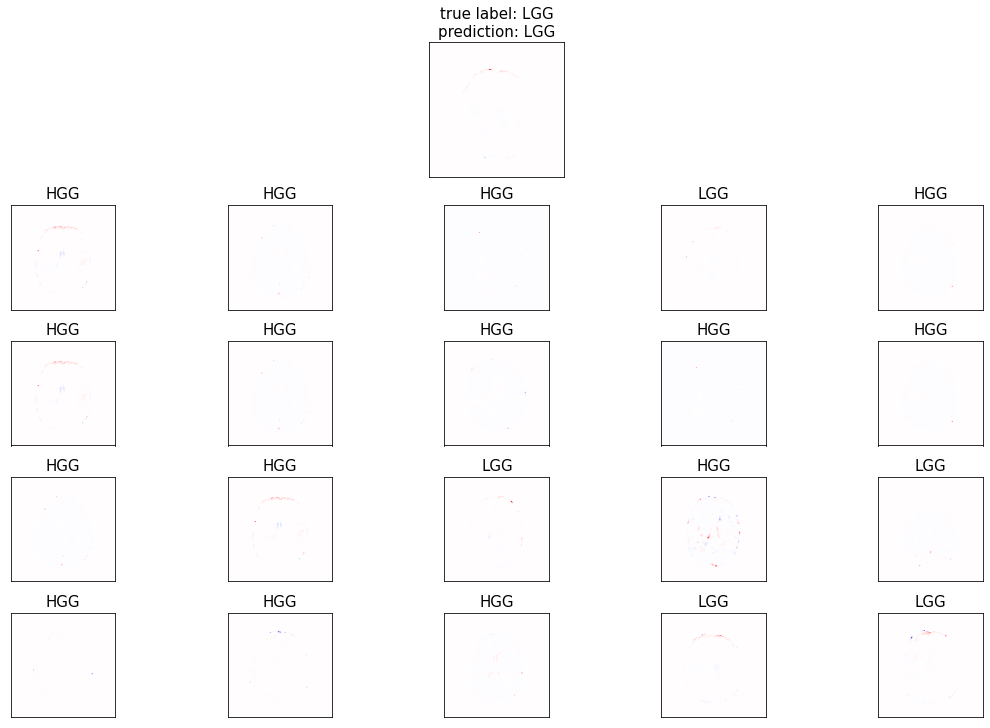

In [64]:
fig3 = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig3.add_gridspec(2, 2, height_ratios = [1, 3])
visualization.visualize_single_lrp(
    image,
    true_label,
    label,
    analyzer,
    ["LGG", "HGG"],
    gs[0,:]
)
visualization.visualize_path_lrp(
    layers_neighbours_idxs,
    test_images,
    test_labels,
    analyzer,
    ["LGG", "HGG"],
    gs[1,:]
)